In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)


#tf.data：构建 TensorFlow 输入流水线

#tf.data API 引入了一个 tf.data.Dataset 抽象，它表示一个元素序列，其中每个元素都由一个或多个组件组成。
#例如，在一个图像流水线中，一个元素可能是一个训练样本，有一对表示图像及其标签的张量组件。

#您可以通过两种不同的方式创建数据集：
#   数据源从存储在内存中或存储在一个或多个文件中的数据构造 Dataset。
#   数据转换从一个或多个 tf.data.Dataset 对象构造数据集。


In [2]:
### 6.1.1 基本机制
#要创建输入流水线，您必须从数据源开始。例如，要从内存中的数据构造一个 Dataset，您可以使用 tf.data.Dataset.from_tensors() 
#或 tf.data.Dataset.from_tensor_slices()。或者，如果您的输入数据以推荐的 TFRecord 格式存储在文件中，则您可以使用 tf.data.TFRecordDataset()。

#有了一个 Dataset 对象之后，您可以通过链接 tf.data.Dataset 对象上的方法调用将其转换成一个新的 Dataset。
#例如，您可以应用逐元素转换（例如 Dataset.map）和多元素转换（例如 Dataset.batch）。有关完整的转换列表，请参阅 tf.data.Dataset 文档。

#Dataset 对象是一个 Python 可迭代对象。这使得利用 for 循环使用它的元素成为可能：
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset


<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


In [5]:
#或者使用 iter 显式创建一个 Python 迭代器，并利用 next 来使用它的元素：
it = iter(dataset)
print(next(it).numpy())

8


In [6]:
## 数据集结构
#数据集会生成一系列元素，其中每个元素都是组件的相同（嵌套）结构。结构的各个组件可以是可由 tf.TypeSpec 表示的任何类型，
#包括 tf.Tensor、tf.sparse.SparseTensor、tf.RaggedTensor、tf.TensorArray 或 tf.data.Dataset。

#可用于表达元素的（嵌套）结构的 Python 构造包括 tuple、dict、NamedTuple 和 OrderedDict。特别要指出的是，list 不是用于表达数据集元素结构的有效构造。
#这是因为早期的 tf.data 用户坚决要求将 list 输入（例如，传递到 tf.data.Dataset.from_tensors 时）自动打包为张量，并将 list 输出（例如，用户定义函数的返回值）强制转换为 tuple。
#因此，如果您希望将 list 输入视为结构，则需要将其转换为 tuple，而如果要将 list 输出作为单个组件，则需要使用 tf.stack 将其显式打包。

#Dataset.element_spec 属性允许您检查每个元素组件的类型。该属性会返回 tf.TypeSpec 对象与元素结构相匹配的嵌套结构，可以是单个组件、组件元组，或者组件的嵌套元组。例如：
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [7]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [8]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [9]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [10]:
#Dataset 转换支持任何结构的数据集。使用 Dataset.map 和 Dataset.filter 转换时会将函数应用于每个元素，而元素结构会决定函数的参数：
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<_TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [11]:
for z in dataset1:
  print(z.numpy())

[6 7 1 3 8 4 7 8 3 4]
[5 7 3 2 5 3 6 9 1 1]
[2 8 1 1 1 9 1 2 1 1]
[6 3 4 7 5 8 5 9 9 1]


In [12]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

In [13]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<_ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))>

In [14]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


In [ ]:
### 6.1.2 读取输入数据  - 网络故障，未运行
## 1.使用Numpy数组
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset


In [ ]:
## 2.使用 Python 生成器
#另一个可被轻松整合为 tf.data.Dataset 的常用数据源是 Python 生成器。
#小心：虽然这种方式比较简便，但它的可移植性和可扩缩性有限。它必须在创建生成器的同一 Python 进程中运行，且仍受 Python GIL 约束。

In [15]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [16]:
for n in count(5):
  print(n)

0
1
2
3
4


In [17]:
#Dataset.from_generator 构造函数会将 Python 生成器转换为具有完整功能的 tf.data.Dataset。
#构造函数会获取可调用对象作为输入，而非迭代器。这样，构造函数结束后便可重启生成器。构造函数会获取一个可选的 args 参数，作为可调用对象的参数。
#output_types 参数是必需的，因为 tf.data 会在内部构建 tf.Graph，而计算图边缘需要 tf.dtype。
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


In [ ]:
## 3 处理 TFRecord 数据 -   - 网络故障，未运行
#tf.data API 支持多种文件格式，因此可以处理不适合存储在内存中的大型数据集。
#例如，TFRecord 文件格式是一种简单的、面向记录的二进制格式，许多 TensorFlow 应用都将其用于训练数据。
#您可以利用 tf.data.TFRecordDataset 类将一个或多个 TFRecord 文件的内容作为输入流水线的一部分进行流式传输。

#下面的示例使用了来自 French Street Name Signs (FSNS) 的测试文件。
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec",
                                          "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

In [ ]:
#TFRecordDataset 初始值设定项的 filenames 参数可以是字符串、字符串列表，或由字符串组成的 tf.Tensor。
#因此，如果您有两组分别用于训练和验证的文件，则可以创建一个工厂方法来生成数据集，并将文件名作为输入参数：
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

In [ ]:
#许多 TensorFlow 项目在其 TFRecord 文件中使用序列化的 tf.train.Example 记录。这些记录需要在检查前进行解码：
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

In [ ]:
## 4 使用 CSV 数据 -  网络故障，未运行
#CSV 文件格式是一种以纯文本形式存储表格数据的流行格式。
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [ ]:
df = pd.read_csv(titanic_file)
df.head()

In [ ]:
#如果您的数据适合存储在内存中，那么 Dataset.from_tensor_slices 方法对字典同样有效，使这些数据可以被轻松导入：
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

In [21]:
### 6.1.3 批处理数据集元素

## 1.简单批处理
#最简单的批处理方式是将数据集的 n 个连续元素堆叠成单个元素。Dataset.batch() 转换就负责执行此操作，
#它有和 tf.stack() 算子相同的约束，应用于元素的每个组件：也就是说，对于每个组件 i，所有元素都必须有一个形状完全相同的张量。
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch],'\n')

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)] 

[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)] 

[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)] 

[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)] 



In [ ]:
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch],'\n')

In [22]:
#当 tf.data 试图传播形状信息时，Dataset.batch 的默认设置会导致未知的批次大小，因为最后一个批次可能不完整。请注意形状中的 None：
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
#使用 drop_remainder 参数忽略最后一个批次，以获得完整的形状传播：
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

In [49]:
## 2.批处理带填充的张量  - 很重要，DIN等序列模型必须要处理这种情况
#上述方式适用于所有具有相同大小的张量。然而，许多模型（包括序列模型）处理的输入数据可能具有不同的大小（例如，长度不同的序列）。
#为了处理这种情况，可以通过 Dataset.padded_batch 转换指定一个或多个可能被填充的维度，从而批处理不同形状的张量。
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))

for batch in dataset.take(8):
  print(batch.numpy())
  print()

[]

[1]

[2 2]

[3 3 3]

[4 4 4 4]

[5 5 5 5 5]

[6 6 6 6 6 6]

[7 7 7 7 7 7 7]



In [50]:
dataset = dataset.padded_batch(batch_size = 2, padded_shapes=(None,))   #每个batch内补齐
for batch in dataset.take(4):
  print(batch.numpy())
  print()

[[0]
 [1]]

[[2 2 0]
 [3 3 3]]

[[4 4 4 4 0]
 [5 5 5 5 5]]

[[6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



In [ ]:
### 6.1.4 训练工作流 - 网络故障，未运行
## 1.处理多个周期
#tf.data API 提供了两种主要方式来处理同一数据的多个周期。
#要在多个周期内迭代数据集，最简单的方式是使用 Dataset.repeat() 转换。首先，创建一个由 Titanic 数据组成的数据集：
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

In [ ]:
#如果应用不带参数的 Dataset.repeat() 转换，将无限次地重复输入。
#Dataset.repeat 转换会连接其参数，而不会在一个周期结束和下一个周期开始时发出信号。因此，在 Dataset.repeat 之后应用的 Dataset.batch 将生成跨越周期边界的批次：
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

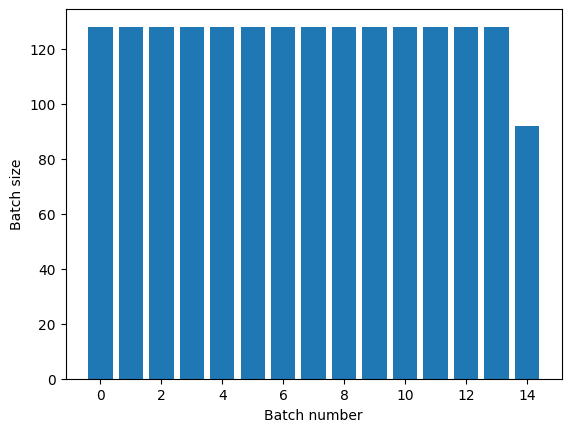

In [ ]:
#如果您需要明确的周期分隔，请将 Dataset.batch 置于重复前：
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

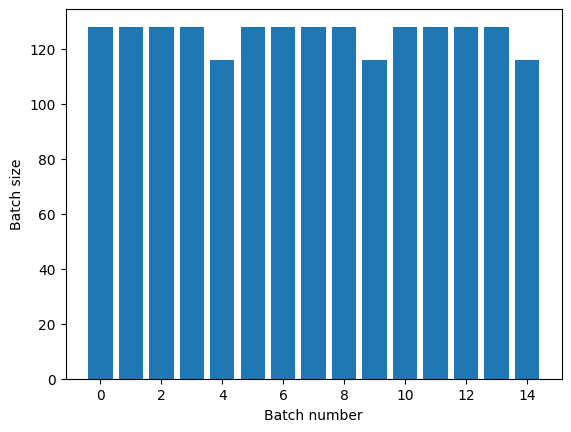

In [ ]:
## 2.随机重排输入数据
#Dataset.shuffle() 转换会维持一个固定大小的缓冲区，并从该缓冲区均匀地随机选择下一个元素：
#注：虽然较大的 buffer_size 可以更彻底地重排，但可能会占用大量的内存和时间来填充。

#向数据集添加索引，便能看到效果：
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset



In [ ]:
#由于 buffer_size 是 100，而批次大小是 20，第一个批次不包含索引大于 120 的元素。
n,line_batch = next(iter(dataset))
print(n.numpy())

In [ ]:
#对于 Dataset.batch，与 Dataset.repeat 的相对顺序很重要。
#在重排缓冲区为空之前，Dataset.shuffle 不会发出周期结束的信号。因此，置于重复之前的重排会先显示一个周期内的每个元素，然后移至下一个周期：
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

In [ ]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

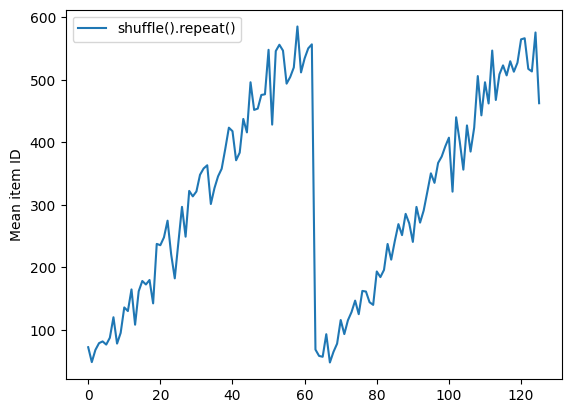

In [ ]:
#但在重排之前的重复会将周期边界混合在一起：
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

  

In [ ]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

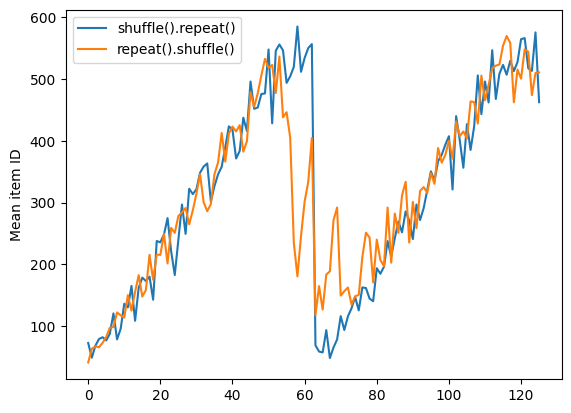

In [ ]:
### 6.1.5 迭代器检查点操作 - 重要，但是增量训练场景下又不那么重要
#TensorFlow 支持获取检查点 ，这样当训练过程重启时，可以还原至最新的检查点，从而恢复大部分进度。除了可以对模型变量进行检查点操作外，您还可以为数据集迭代器的进度设置检查点。如果您有一个很大的数据集，并且不想在每次重启后都从头开始，此功能会非常有用。但是请注意，迭代器检查点可能会很大，因为像 Dataset.shuffle 和 Dataset.prefetch 之类的转换需要在迭代器内缓冲元素。

#要在检查点中包含迭代器，请将迭代器传递至 tf.train.Checkpoint 构造函数。
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

In [ ]:
### 6.1.6 结合使用 tf.data 与 tf.keras - 网络故障，未运行
#tf.keras API 在创建和执行机器学习模型的许多方面进行了简化。
#它的 Model.fit、Model.evaluate 和 Model.predict API 支持将数据集作为输入。下面是一个快速的数据集和模型设置：
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [ ]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
#只需向 Model.fit 和 Model.evaluate 传递一个由 (feature, label) 对组成的数据集：
model.fit(fmnist_train_ds, epochs=2)

In [ ]:
#如果您要传递一个无限大的数据集（比如通过调用 Dataset.repeat），您只需要同时传递 steps_per_epoch 参数：
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

In [ ]:
#对于评估，可以传递评估步数：
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

In [ ]:
#对于长数据集，可以设置要评估的步数：
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

In [ ]:
#调用 Model.predict 时不需要标签。
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

In [ ]:
#但是，如果您传递了包含标签的数据集，则标签会被忽略：
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

In [86]:
###<补充> 6.1.7 keras读取tfrecord格式样本训练模型 - 重要，工业界基本都使用tfrecord格式传输/存储样本

## 1.构造tfrecord样本

#import os  
import tensorflow as tf  
import numpy as np  
  
# 设定数据大小  
num_samples = 1000  
image_size = 784  # 假设图像是 28x28，则 flatten 后大小为 784  
num_classes = 10  # 假设有 10 个类别  
  
# 生成随机图像数据  
images = np.random.rand(num_samples, image_size).astype(np.float32)  
  
# 生成随机标签数据  
labels = np.random.randint(num_classes, size=(num_samples, 1), dtype=np.int32)  
  
# 定义一个函数来将图像和标签写入 TFRecord  
def write_tfrecord(images, labels, output_path):  
    with tf.io.TFRecordWriter(output_path) as writer:  
        for image, label in zip(images, labels):  
            # 创建一个 tf.train.Example 对象  
            example = tf.train.Example(features=tf.train.Features(feature={  
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image.flatten())),  
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)]))  
            }))  
              
            # 将 tf.train.Example 序列化为字符串并写入 TFRecord 文件  
            writer.write(example.SerializeToString())  
        print(example)
# 生成 TFRecord 文件  
output_path = '__TFRecord/train.tfrecord'  
write_tfrecord(images, labels, output_path)


C:\Users\yuanshuai\AppData\Local\Temp\ipykernel_22648\1921210607.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)]))


features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      float_list {
        value: 0.0267980602
        value: 0.188709766
        value: 0.857878268
        value: 0.0523615852
        value: 0.615810215
        value: 0.963908255
        value: 0.563105583
        value: 0.216997728
        value: 0.952024281
        value: 0.433552533
        value: 0.259844
        value: 0.613800406
        value: 0.50800252
        value: 0.877192199
        value: 0.986385167
        value: 0.476436436
        value: 0.609690666
        value: 0.600470603
        value: 0.542124
        value: 0.673573256
        value: 0.324994713
        value: 0.0994925573
        value: 0.645085
        value: 0.711700737
        value: 0.585840285
        value: 0.840572774
        value: 0.27299729
        value: 0.0564912707
        value: 0.463685691
        value: 0.783679724
        value: 0.247664049
    

In [77]:
images.shape

(1000, 784)

In [80]:
images[0:2]

array([[0.903 , 0.2253, 0.2937, ..., 0.8666, 0.7277, 0.8869],
       [0.5293, 0.0978, 0.7204, ..., 0.221 , 0.8307, 0.3823]],
      dtype=float32)

In [78]:
labels.shape

(1000, 1)

In [81]:
labels[:2]

array([[1],
       [0]])

In [160]:
## 2.读取并解析tfrecord样本
import tensorflow as tf  
import numpy as np  
  
# 定义解析函数，用于从 TFRecord 中提取图像和标签  
def parse_example(example_proto):  
    features = {  
        'image': tf.io.FixedLenFeature([784,], tf.float32),   #要指定shape，否则默认是1个元素
        'label': tf.io.FixedLenFeature([], tf.int64),          #只有一个元素，默认空即刻
    }  
    parsed_features = tf.io.parse_single_example(example_proto, features)  
    print("parsed_features:",parsed_features)
    print("image:",parsed_features['image'])
    print("label:",parsed_features['label'])


    # 标准化图像到 [0, 1] 范围  
    image = tf.reshape(parsed_features['image'], (28, 28, 1)) 
    # 将标签转换为整数  
    label = tf.cast(parsed_features['label'], tf.int64)  
    # 可能还需要调整图像大小等预处理步骤  
    # image = tf.image.resize(image, [height, width])  
    return image, label  
  


# 加载数据集  
# 假设我们有一个 TFRecord 文件 'train.tfrecord'  
tfrecord_file = '__TFRecord/train.tfrecord'  
dataset = tf.data.TFRecordDataset(tfrecord_file)  
dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)  
train_dataset = dataset.shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE)    

# 从数据集中获取一个样本以检查形状  
sample_image, sample_label = next(iter(train_dataset))  
print("Image shape:", sample_image.shape)  
print("Label shape:", sample_label.shape)



parsed_features: {'image': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(784,) dtype=float32>, 'label': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=int64>}
image: Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(784,), dtype=float32)
label: Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
Image shape: (16, 28, 28, 1)
Label shape: (16,)


In [161]:
dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [162]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [165]:

## 3.训练模型 - 数据集中指定batch
  
# 定义一个简单的模型
import keras
from keras import layers
  
model = keras.Sequential(
    [
        layers.Flatten(input_shape=[ 28, 28, 1], name="inputs"),
        layers.Dense(512, activation="relu", name="layer1"),
        layers.Dense(512, activation="relu", name="layer2"),
        layers.Dense(10, activation="softmax",name="predictions"), 
    ]
)
  
# 编译模型  
model.compile(optimizer='adam',  
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  #需要注意的是，
                                                    #如果你的模型输出已经是概率分布（即已经通过 softmax 层），
                                                    #那么你应该使用 from_logits=False 或者简单地使用 tf.keras.losses.SparseCategoricalCrossentropy()
                                                    #（默认 from_logits 为 False）。在这种情况下，你不应该在模型的最后一层使用 softmax 激活函数，
                                                    #以避免对概率进行重复 softmax 操作。
              metrics=['accuracy'])  
  
# 训练模型  
model.fit(train_dataset, epochs=10)  #随机数据，先不关注效果，关注流程

Epoch 1/10


63/63 [==============================] - 3s 21ms/step - loss: 2.3855 - accuracy: 0.1040
Epoch 2/10
63/63 [==============================] - 1s 18ms/step - loss: 2.2995 - accuracy: 0.1210
Epoch 3/10
63/63 [==============================] - 1s 19ms/step - loss: 2.2937 - accuracy: 0.1240
Epoch 4/10
63/63 [==============================] - 1s 15ms/step - loss: 2.2568 - accuracy: 0.1740
Epoch 5/10
63/63 [==============================] - 1s 16ms/step - loss: 2.2290 - accuracy: 0.1710
Epoch 6/10
63/63 [==============================] - 1s 14ms/step - loss: 2.1555 - accuracy: 0.2280
Epoch 7/10
63/63 [==============================] - 1s 15ms/step - loss: 1.9739 - accuracy: 0.3190
Epoch 8/10
63/63 [==============================] - 1s 17ms/step - loss: 1.9262 - accuracy: 0.3340
Epoch 9/10
63/63 [==============================] - 1s 17ms/step - loss: 1.6313 - accuracy: 0.4550
Epoch 10/10
63/63 [==============================] - 1s 15ms/step - loss: 1.3967 - accuracy: 0.5290


In [164]:
## 迭代训练多个batch - model.fit参数指定batch
          
import numpy as np  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.optimizers import Adam  
  
# 创建一个简单的模型  
model = Sequential()  
model.add(Dense(32, input_dim=10, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))  
  
# 编译模型  
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])  
  
# 生成随机数据  
x_train = np.random.random((1000, 10))  
y_train = np.random.randint(2, size=(1000, 1))  
  
# 使用model.fit训练模型  
model.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
50/50 [==============================] - 2s 18ms/step - loss: 0.7128 - accuracy: 0.5175 - val_loss: 0.6913 - val_accuracy: 0.5250
Epoch 2/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6996 - accuracy: 0.4975 - val_loss: 0.6907 - val_accuracy: 0.5800
Epoch 3/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6976 - accuracy: 0.5088 - val_loss: 0.6911 - val_accuracy: 0.5450
Epoch 4/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.5138 - val_loss: 0.6913 - val_accuracy: 0.5350
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6954 - accuracy: 0.5063 - val_loss: 0.6919 - val_accuracy: 0.5200
Epoch 6/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6943 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.4900
Epoch 7/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5238 - val_loss: 0.6925 - val_accuracy: 0.5400
Epoch 8/10
50/50 [=